# **CNN Identificación y localización de Gatos y Perros**                               

Autor:
[Jorge Lizarazo](https://www.researchgate.net/profile/Jorge-Lizarazo-Borrero)

**5/11/2023**
Fundamentos de Analitica II
______________________________
Evaluado por el Asistente de docensia [Ms Daniel Osorio](https://co.linkedin.com/in/daniel-osorio-33aba4125) y el profesor  
[PhD Javier Diaz Cely](https://www.linkedin.com/in/javierdiazcely/)


## Introducción
Realizamos una mejorar de un modelo de aprendizaje profundo especializado en la clasificación binaria de gatos y perros y localización de estos. El proyecto comienza con la preparación de los datos, donde se implementan transformaciones y aumentos de imágenes, como la normalización, el cambio de escala y técnicas conservadoras de aumento para mejorar la robustez del modelo. Estas transformaciones son esenciales para preparar los datos de entrada de manera que sean adecuados para el procesamiento mediante redes neuronales convolucionales. En general solo se mostraran las modificaciones realizadas sobre el notebook base dispuestos en la competencia de [Kaggle](https://www.kaggle.com/competitions/af-ii-2023-ii-object-localization/overview).

Realizamos una mejorar de un modelo de aprendizaje profundo especializado en la clasificación binaria de gatos y perros y localización de estos. El proyecto comienza con la preparación de los datos, donde se implementan transformaciones y aumentos de imágenes, como la normalización, el cambio de escala y técnicas conservadoras de aumento para mejorar la robustez del modelo. Estas transformaciones son esenciales para preparar los datos de entrada de manera que sean adecuados para el procesamiento mediante redes neuronales convolucionales. En general solo se mostrarán las modificaciones realizadas sobre el notebook base dispuestos en la competencia de Kaggle realizada por el monitor o asistente de docencia.
Para el Transfer Learning, se usaba inicialmente una arquitectura VGG16 y luego fue cambiada a una [ResNet50](https://keras.io/api/applications/resnet/) preentrenada para extraer características con mayor eficacia, esto por sí solo logro un avance gigantesco en los “score” seleccionados para la clasificación. La adaptación de la red a las necesidades específicas del conjunto de datos se realiza a través de cabezas clasificadoras y regresoras personalizadas.
La experimentación continua no logro grandez avances en la clasificación, pero entonces se avanzó en la data “augmentation” se logro una mejora en la localización de gatos y perros. y la optimización dentro del código, incluyendo la introducción de la normalización por lotes y tasas de aprendizaje diferenciales, mejora incremental del modelo, de manera muy baja en la clasificación, pero un poco más alta en la localización.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchsummary
!pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=7ca1ce8413d985c54dfcbafbe47950b39fe3175cb25c836b599ca29352a07049
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [3]:
import pandas as pd

# Dirección del directorio y archivo de anotaciones
folder_path = '/content/drive/MyDrive/data_Taller_2/dataset'

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from __future__ import print_function, division

import numpy as np # linear algebra

from numpy.typing import NDArray
from functools import reduce
from itertools import islice
import wandb
import math
from itertools import chain
import copy

import torch
from torch import nn
from torch import Tensor
from torch.optim import Optimizer
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary
# Import albumentations library in order to -use pre-built augmentations
import albumentations as A

from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count

import os
import torch
import os.path as osp
from skimage import io, transform
import matplotlib.pyplot as plt
import typing as ty
import cv2

plt.ion()   # interactive mode

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Listar los primeros 10 archivos del directorio
for root, dirs, filenames in os.walk(folder_path):
    for i, filepath in enumerate(filenames):
        if i >= 10:
            print()
            break
        print(osp.join(root, filepath))

/content/drive/MyDrive/data_Taller_2/dataset/test.csv
/content/drive/MyDrive/data_Taller_2/dataset/train.csv
/content/drive/MyDrive/data_Taller_2/dataset/sample_submission.csv
/content/drive/MyDrive/data_Taller_2/dataset/images/image.239.jpg
/content/drive/MyDrive/data_Taller_2/dataset/images/image.147.jpg
/content/drive/MyDrive/data_Taller_2/dataset/images/image.291.jpg
/content/drive/MyDrive/data_Taller_2/dataset/images/image.3244.jpg
/content/drive/MyDrive/data_Taller_2/dataset/images/image.284.jpg
/content/drive/MyDrive/data_Taller_2/dataset/images/image.3230.jpg
/content/drive/MyDrive/data_Taller_2/dataset/images/image.3281.jpg
/content/drive/MyDrive/data_Taller_2/dataset/images/image.22.jpg
/content/drive/MyDrive/data_Taller_2/dataset/images/image.163.jpg
/content/drive/MyDrive/data_Taller_2/dataset/images/image.103.jpg



In [5]:
torch.manual_seed(32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')
test = torch.ones((100, 100)).to(device)
del test
torch.cuda.empty_cache()

Using cuda


In [6]:
import os.path as osp


# Dirección del directorio donde guardaste los datos en Google Drive
DATA_DIR = '/content/drive/MyDrive/data_Taller_2/dataset'
WORK_DIR = '/content/drive/MyDrive/'  # Ajusta si tienes un directorio de trabajo específico en Google Drive
BATCH_SIZE = 32

img_dir = osp.join(DATA_DIR, "images")
h, w, c = 256, 256, 3  # The height, width, and number of channels of each image

# Here we map each class to an index from 0 to n_classes - 1
obj2id = {
    "cat": 0,
    "dog": 1
}

id2obj = {
    0: "cat",
    1: "dog"
}

df = pd.read_csv(osp.join(DATA_DIR, "train.csv"))
df["class_id"] = df["class"].map(obj2id)
df[["xmin", "ymin", "xmax", "ymax"]] /= h

train_df, val_df = train_test_split(
    df, stratify=df['class_id'], test_size=0.25
)

print(train_df.shape)
print(val_df.shape)

test = pd.read_csv(osp.join(DATA_DIR, "test.csv"))
print(os.listdir(DATA_DIR))

(756, 7)
(252, 7)
['test.csv', 'train.csv', 'sample_submission.csv', 'images']


In [7]:
classes = df["class"].unique()
classes

array(['dog', 'cat'], dtype=object)

In [8]:
df.shape

(1008, 7)

In [9]:
df.head()

,filename,class,xmin,ymin,xmax,ymax,class_id
0,image.3240.jpg,dog,0.053531,0.016949,0.980085,0.966102,1
1,image.273.jpg,cat,0.021893,0.041808,1.000000,0.983051,0
2,image.775.jpg,cat,0.007203,0.015537,0.768362,1.000000,0
3,image.733.jpg,cat,0.149011,0.000000,0.718503,0.995480,0
4,image.3262.jpg,dog,0.085170,0.176271,0.625283,1.000000,1


In [10]:
test.head()

,filename
0,image.3401.jpg
1,image.3325.jpg
2,image.3242.jpg
3,image.3218.jpg
4,image.797.jpg


In [11]:
train_df['class'].value_counts(1) * 100

dog    50.0
cat    50.0
Name: class, dtype: float64

In [12]:
val_df['class'].value_counts(1) * 100

dog    50.0
cat    50.0
Name: class, dtype: float64

## Bounding boxes y clasificacion para verificaciones

In [13]:
transform_func_inp_signature = ty.Dict[str, NDArray[np.float_]]
transform_func_signature = ty.Callable[
    [transform_func_inp_signature],
    transform_func_inp_signature
]

class PetsDataset(Dataset):
    """
    Location Pets dataset
    """
    def __init__(
        self,
        df: pd.DataFrame,
        root_dir: str,
        labeled: bool = True,
        transform: ty.Optional[ty.List[transform_func_signature]] = None
    ) -> None:
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx: int) -> transform_func_signature:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read image
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        image = io.imread(img_name)

        # Convert from BGR to RGB
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        sample = {'image': image}

        if self.labeled:
            # Read labels
            img_class = self.df.class_id.iloc[idx]
            #name_class = self.df['class'].iloc[idx]
            img_bbox = self.df.iloc[idx, 2:6]

            img_bbox = np.array([img_bbox]).astype('float')
            img_class = np.array([img_class]).astype('int')
            sample.update({'bbox': img_bbox, 'class_id': img_class})#,'name_class':name_class

        if self.transform:
            sample = self.transform(sample)

        return sample

In [14]:
'''
dataframe_path = "/content/drive/MyDrive/data_Taller_2/dataset/train.csv"  # Ajusta según la ubicación real de tu dataframe
root_directory = "/content/drive/MyDrive/data_Taller_2/dataset/images"  # Ajusta según la ubicación real de tus imágenes

df = pd.read_csv(dataframe_path)
pets_dataset = PetsDataset(df, root_directory)
'''

'\ndataframe_path = "/content/drive/MyDrive/data_Taller_2/dataset/train.csv"  # Ajusta según la ubicación real de tu dataframe\nroot_directory = "/content/drive/MyDrive/data_Taller_2/dataset/images"  # Ajusta según la ubicación real de tus imágenes\n\ndf = pd.read_csv(dataframe_path)\npets_dataset = PetsDataset(df, root_directory)\n'

In [15]:
def draw_bbox(img, bbox, color):
    xmin, ymin, xmax, ymax = bbox
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
    return img

def normalize_bbox(bbox, factor: int = 256):
    return list(map(lambda x: int(x * factor), bbox))

def draw_bboxes(imgs, bboxes, colors):
    for i, (img, bbox, color) in enumerate(zip(imgs, bboxes, colors)):
        imgs[i] = draw_bbox(img, bbox, color)
    return imgs

def draw_classes(imgs, classes, colors, origin, offset: int = 5, prefix: str =''):
    for i, (img, class_id, color) in enumerate(zip(imgs, classes, colors)):
        if type(c)==list:
            name_class_=id2obj[classes[i]]
        else:
            name_class_=id2obj[classes[i][0]]
        imgs[i] = cv2.putText(
            img, f'{prefix}{name_class_}', #class_id.squeeze()
            origin, cv2.FONT_HERSHEY_SIMPLEX,
            0.4, color, 1, cv2.LINE_AA
        )
    return imgs

def draw_predictions(imgs, classes, bboxes, colors, origin):
    assert all(len(x) > 0 for x in [imgs, classes, bboxes, colors])
    if len(colors) == 1:
        colors = [colors[0] for _ in imgs]
    imgs = draw_bboxes(imgs, bboxes, colors)
    imgs = draw_classes(imgs, classes, colors, origin)
    return imgs

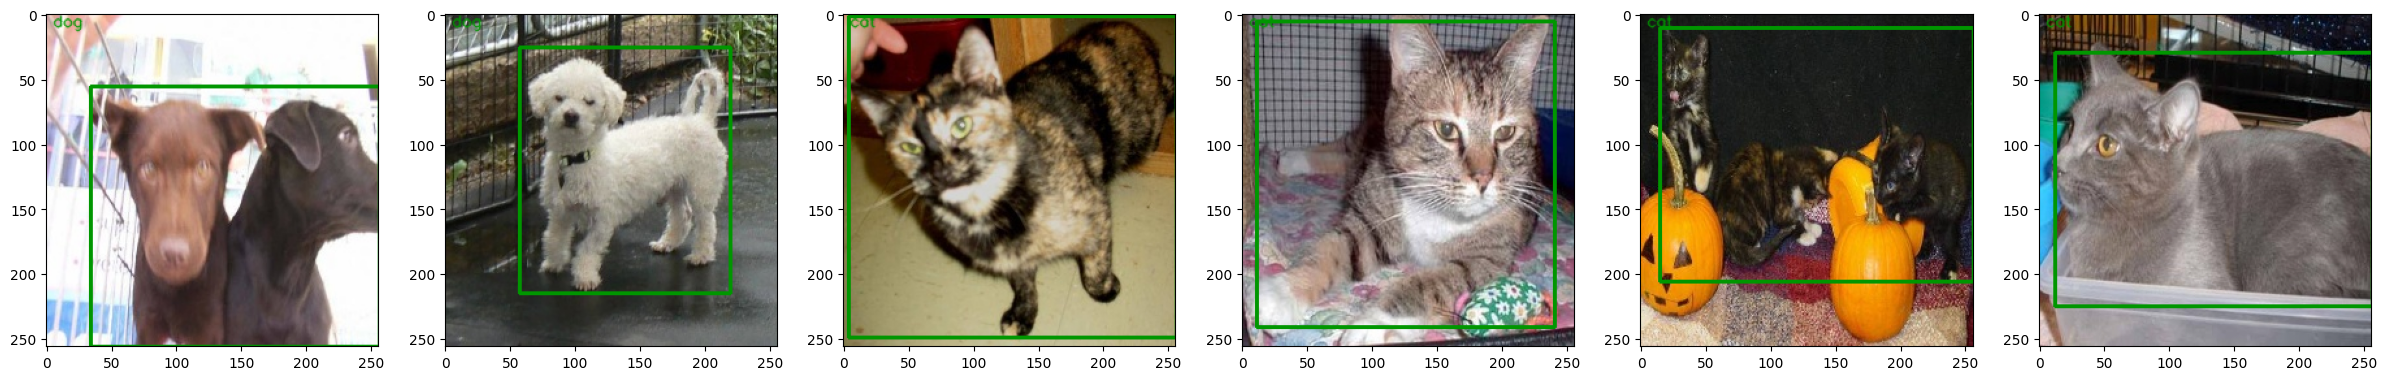

In [16]:
train_root_dir = osp.join(DATA_DIR, "images")#, "train"
train_ds = PetsDataset(train_df, root_dir=train_root_dir)

num_imgs = 6
start_idx = 0

samples = [train_ds[i] for i in range(start_idx, num_imgs)]

imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze()) for s in samples]
classes = [s['class_id'] for s in samples]

imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (5, 10))#(150, 10)

fig = plt.figure(figsize=(30, num_imgs))

for i, img in enumerate(imgs):
    fig.add_subplot(1, num_imgs, i+1)
    plt.imshow(img)

plt.show()

In [17]:
samples[2]['class_id']

array([0])

In [18]:
samples[2]['image']

array([[[206, 146, 109],
        [205, 145, 108],
        [206, 148, 111],
        ...,
        [ 60,  41,  11],
        [ 62,  43,  13],
        [ 55,  36,   6]],

       [[208, 148, 112],
        [206, 148, 111],
        [207, 149, 112],
        ...,
        [  0, 150,   0],
        [  0, 150,   0],
        [  0, 150,   0]],

       [[210, 151, 117],
        [207, 151, 116],
        [207, 151, 116],
        ...,
        [  0, 150,   0],
        [  0, 150,   0],
        [  0, 150,   0]],

       ...,

       [[126, 119,  73],
        [129, 122,  76],
        [133, 125,  79],
        ...,
        [174, 165, 122],
        [174, 166, 120],
        [176, 168, 122]],

       [[121, 115,  67],
        [126, 120,  72],
        [132, 124,  78],
        ...,
        [175, 167, 121],
        [178, 170, 124],
        [176, 168, 122]],

       [[118, 112,  64],
        [125, 119,  71],
        [131, 123,  77],
        ...,
        [175, 167, 121],
        [179, 171, 125],
        [176, 168, 122]]


# Transfer learning


Al principio estaba usando VGG16 para mi proyecto de clasificación de imágenes, pero luego cambié a ResNet50 y funcionó mejor. VGG16 estaba bien, pero ResNet50 tiene estas cosas llamadas conexiones residuales que ayudan a entrenar redes más profundas, y eso ayuda a que el modelo entienda mejor las fotos. En mi código, usé la mayor parte de ResNet50 tal cual, excepto que le puse un tipo especial de capa de agrupamiento. Esto luego de varios intentos desde una selección menos sofisticada. Tambien coloque la opción para no tocara los pesos ya entrenados de ResNet. Esto fue clave porque en principio cuando no lo hice el score de clasificación era muy similar al VGG16. Creo que esto se debe a que ResNet ya “sabe mucho” de otros trabajos con el que fue entrenado arduamente para su creación.

In [19]:
from torchvision.models import resnet50

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        # Everything except the final layer
        self.features = nn.Sequential(*list(model.children())[:-2])
        self.pooling = nn.AdaptiveAvgPool2d((1, 1)) # Capa especial de agrupamiento
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.features(x)
        out = self.pooling(out) # Aplicación de la capa de agrupamiento aquí
        out = self.flatten(out)
        out = self.dropout(out)
        return out

# Load the ResNet50 model
resnet50_model = resnet50(pretrained=True)
# Disable grad for all conv layers
for param in resnet50_model.parameters():
    param.requires_grad = False # Indica que no se entrenen los pesos

pretrained_model = FeatureExtractor(resnet50_model).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


In [20]:
summary(pretrained_model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [21]:
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
samples[2]['image']

array([[[206, 146, 109],
        [205, 145, 108],
        [206, 148, 111],
        ...,
        [ 60,  41,  11],
        [ 62,  43,  13],
        [ 55,  36,   6]],

       [[208, 148, 112],
        [206, 148, 111],
        [207, 149, 112],
        ...,
        [  0, 150,   0],
        [  0, 150,   0],
        [  0, 150,   0]],

       [[210, 151, 117],
        [207, 151, 116],
        [207, 151, 116],
        ...,
        [  0, 150,   0],
        [  0, 150,   0],
        [  0, 150,   0]],

       ...,

       [[126, 119,  73],
        [129, 122,  76],
        [133, 125,  79],
        ...,
        [174, 165, 122],
        [174, 166, 120],
        [176, 168, 122]],

       [[121, 115,  67],
        [126, 120,  72],
        [132, 124,  78],
        ...,
        [175, 167, 121],
        [178, 170, 124],
        [176, 168, 122]],

       [[118, 112,  64],
        [125, 119,  71],
        [131, 123,  77],
        ...,
        [175, 167, 121],
        [179, 171, 125],
        [176, 168, 122]]

Me quede con el promedo del set de entrenamiento tanto para el data augmentation como para el test y submission. debido a que la diferencia en el score usando ma media y desviacion total de la data set y del train era insignificante, apenas unas pocas decimas en el score de clasificacion y localizacion.  

In [23]:


train_ds = PetsDataset(train_df, root_dir=train_root_dir)

means = None # [192.7398838152939, 190.94339673431622, 181.09955913748954]
stds = None # [83.23730414690347, 84.07248256814508, 92.48922372831]

if means is None and stds is None:
    means, stds = [], []
    pixel_values = [
        [], # R, size = H * W * num_images
        [], # G size = H * W * num_images
        [], # B size = H * W * num_images
    ]

    for x in train_ds:
        img = x['image']

        for channel in range(3):
            channel_pixel_values = list(img[..., channel].flatten())
            pixel_values[channel].extend(channel_pixel_values)

    for channel in range(3):
        means.append(np.mean(pixel_values[channel]))
        stds.append(np.std(pixel_values[channel]))

    del pixel_values


print(means)
print(stds)


[124.45272845313663, 115.56325206050167, 106.27709026437587]
[67.14985373564008, 65.46172673425514, 66.43572077133092]


In [ ]:
'''
train_ds = PetsDataset(train_df, root_dir=train_root_dir)

# Valores previamente calculados
means = [124.946471623012, 115.70365540438858, 105.6772274844861]
stds = [66.89046875815292, 65.29113951615507, 66.21621079114422]

print(means)
print(stds)
'''

'\ntrain_ds = PetsDataset(train_df, root_dir=train_root_dir)\n\n# Valores previamente calculados\nmeans = [124.946471623012, 115.70365540438858, 105.6772274844861]\nstds = [66.89046875815292, 65.29113951615507, 66.21621079114422]\n\nprint(means)\nprint(stds)\n'

In [24]:
from torchvision import transforms

# Usando las medias y desviaciones estándar que calculaste
normalize = transforms.Normalize(mean=means, std=stds)

## Image transforms

Se cambiaron solo algunos aspectos en el augmentation, pero nada fuera de lo conservador para evitar problemas o demasiada transformaciones. En general de alguna forma estos pequeños cambios mejoraron notablemente la localizacion dentro del analisis.

In [25]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C (0,1,2)
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).float()
        sample.update({'image': image})
        return sample

class Normalizer(object):

    def __init__(self, stds, means):
        """
        Arguments:

            stds: array of length 3 containing the standard deviation of each channel in RGB order.
            means: array of length 3 containing the means of each channel in RGB order.
        """
        self.stds = stds
        self.means = means

    def __call__(self, sample):
        """
        Sample: a dictionary containing:
            image: sample image in format (C, H, W)
        Returns:
            the image in (C, H, W) format with the channels normalized.
        """
        image = sample['image']

        for channel in range(3):
            image[channel] = (image[channel] - means[channel]) / stds[channel]

        sample['image'] = image
        return sample

class TVTransformWrapper(object):
    """Torch Vision Transform Wrapper
    """
    def __init__(self, transform: torch.nn.Module):
        self.transform = transform

    def __call__(self, sample):
        sample['image'] = self.transform(sample['image'])
        return sample

class AlbumentationsWrapper(object):

    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        transformed = self.transform(
            image=sample['image'],
            bboxes=sample['bbox'],
            #category_ids=sample['class_id']
        )
        sample['image'] = transformed['image']
        sample['bbox'] = np.array(transformed['bboxes'])
        return sample


In [31]:
common_transforms = [
    ToTensor(),
    Normalizer(
        means=means,
        stds=stds,
    )
]

train_data_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ImageCompression(quality_lower=75, quality_upper=100, p=0.5),
    A.Rotate(limit=(-20, 20), p=0.5),
    A.Resize(height=256, width=256, p=1), # p=1 means always apply
    # Agrega transformaciones con una baja probabilidad para mantener la imagen cercana a la original
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.Blur(blur_limit=4, p=0.3),
],
bbox_params=A.BboxParams(
    format='albumentations',
    label_fields=[]#'category_ids'
)
)

train_transforms = torchvision.transforms.Compose(
    [
        AlbumentationsWrapper(train_data_augmentations),
    ] + common_transforms
)

eval_transforms = torchvision.transforms.Compose(common_transforms)

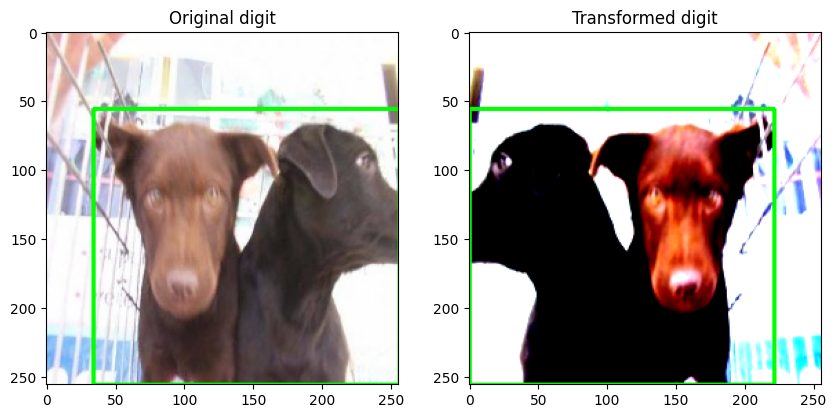

In [28]:
train_ds = PetsDataset(train_df, root_dir=train_root_dir)

x = next(iter(train_ds))
x_transformed = copy.deepcopy(x)
x_transformed = train_transforms(x_transformed)

original_img = x['image']
transformed_img = x_transformed['image'].numpy().transpose(1, 2, 0)

original_img = draw_bbox(
    original_img,
    normalize_bbox(x['bbox'].squeeze()),
    (0, 255, 0)
)

transformed_img = draw_bbox(
    transformed_img,
    normalize_bbox(x_transformed['bbox'].squeeze()),
    (0, 255, 0)
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(original_img)
axes[0].set_title('Original digit')

axes[1].imshow(transformed_img)
axes[1].set_title('Transformed digit')

plt.show()

In [32]:
train_ds = PetsDataset(df, root_dir=train_root_dir, transform=train_transforms)
train_data = torch.utils.data.DataLoader(train_ds, batch_size=32)

for x in train_data:
    print(x['image'].size())
    break

torch.Size([32, 3, 256, 256])


In [33]:
def get_output_shape(model: nn.Sequential, image_dim: ty.Tuple[int, int, int]):
    return model(torch.rand(*(image_dim)).to(device)).data.shape

class Model(nn.Module):
    def __init__(self, input_shape: ty.Tuple[int, int, int] = (3, 256, 256), n_classes: int = 2):
        super().__init__()
        self.input_shape = input_shape
        self.backbone = pretrained_model

        backbone_output_shape = get_output_shape(self.backbone, [1, *input_shape])
        backbone_output_features = reduce(lambda x, y: x*y, backbone_output_shape)


        self.cls_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.BatchNorm1d(768),  # BatchNorm layer
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.BatchNorm1d(256),  # BatchNorm layer
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

        self.reg_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.BatchNorm1d(768),  # BatchNorm layer
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.BatchNorm1d(256),  # BatchNorm layer
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  # BatchNorm layer
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x: Tensor) -> ty.Dict[str, Tensor]:
        features = self.backbone(x)
        cls_logits = self.cls_head(features)
        pred_bbox = self.reg_head(features)
        predictions = {'bbox': pred_bbox, 'class_id': cls_logits}
        return predictions

In [37]:
torch.cuda.empty_cache()

In [38]:
print('image', x['image'].size())
model = Model(input_shape=(3, 256, 256), n_classes=2).to(device)
x['image'] = x['image'].to(device)
preds = model(x['image'])
preds

image torch.Size([32, 3, 256, 256])


{'bbox': tensor([[-0.6493,  0.3651,  0.3721,  0.0265],
         [-0.4991,  0.4998,  0.3651, -1.2311],
         [-0.0699, -0.1710,  0.5894, -0.5878],
         [-0.5131,  0.3131, -0.0413,  0.0163],
         [-0.2908, -0.0547,  0.0741, -0.9905],
         [ 0.0233, -0.1418, -0.2963, -0.5638],
         [-0.3014,  0.2682, -0.0147, -0.6156],
         [ 0.1093,  0.3760, -0.3647, -0.3312],
         [-0.4604, -0.1521, -0.2243, -0.8149],
         [-0.4076, -0.0295, -0.0229, -0.0882],
         [-0.8927,  0.2268, -0.1459, -0.2219],
         [-0.3220, -0.3103,  0.1941,  0.1276],
         [-0.4330, -0.5386, -0.1184, -0.6908],
         [-0.4536,  0.0748, -0.0291, -0.7405],
         [-0.2708, -0.0257, -0.0378, -0.2939],
         [-0.4986, -0.3188, -0.2138, -0.2897],
         [-0.2696, -0.3451,  0.4151, -0.1761],
         [ 0.1474,  0.2307,  0.0749,  0.1239],
         [-1.5748, -0.2834,  0.1724, -0.8721],
         [-0.4878, -0.4636,  0.1264, -0.3056],
         [-0.2785, -0.2972,  0.7259, -0.4609],
     

Aqui agregamos un optimizador "Adam" para ajustar los pesos del modelo, simple previa a la que se da abajo. En algun momento esta adicion mejroro tambien la localizacion.  

In [39]:
optimizer = torch.optim.Adam([
    {'params': model.backbone.parameters(), 'lr': 1e-5},  # Tasas de aprendizaje más bajas para el modelo preentrenado
    {'params': model.cls_head.parameters(), 'lr': 1e-4},
    {'params': model.reg_head.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)  # También añadimos un término de regularización de weight_decay si es necesario

# Metrics

In [40]:
def iou(y_true: Tensor, y_pred: Tensor):
    pairwise_iou = torchvision.ops.box_iou(y_true.squeeze(), y_pred.squeeze())
    result = torch.trace(pairwise_iou) / pairwise_iou.size()[0]
    return result

In [41]:
def accuracy(y_true: Tensor, y_pred: Tensor):
    pred = torch.argmax(y_pred, axis=-1)
    y_true = y_true.squeeze()
    correct = torch.eq(pred, y_true).float()
    total = torch.ones_like(correct)
    result = torch.divide(torch.sum(correct), torch.sum(total))
    return result

# Loss fn

In [42]:
def loss_fn(y_true, y_preds, alpha: float = 0.5):
    cls_y_true, cls_y_pred = y_true['class_id'].long(), y_preds['class_id'].float().unsqueeze(-1)
    reg_y_true, reg_y_pred = y_true['bbox'].float().squeeze(), y_preds['bbox'].float().squeeze()

    cls_loss = F.cross_entropy(cls_y_pred, cls_y_true)

    reg_loss = F.mse_loss(reg_y_pred, reg_y_true)
    # Adds weights to both tasks
    total_loss = (1 - alpha) * cls_loss + alpha * reg_loss
    return dict(loss=total_loss, reg_loss=reg_loss,cls_loss=cls_loss)

# Callbacks

In [43]:
def printer(logs: ty.Dict[str, ty.Any]):
    # print every 10 steps
    if logs['iters'] % 10 != 0:
        return
    print('Iteration #: ',logs['iters'])
    for name, value in logs.items():
        if name == 'iters':
            continue

        if type(value) in [float, int]:
            value = round(value, 4)
        elif type(value) is torch.Tensor:
            value = torch.round(value, decimals=4)

        print(f'\t{name} = {value}')
    print()

# Training loop

In [44]:
def evaluate(
    logs: ty.Dict[str, ty.Any],
    labels: ty.Dict[str, Tensor],
    preds: ty.Dict[str, Tensor],
    eval_set: str,
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    losses: ty.Optional[ty.Dict[str, Tensor]] = None,
) -> ty.Dict[str, ty.Any]:

    if losses is not None:
        for loss_name, loss_value in losses.items():
            logs[f'{eval_set}_{loss_name}'] = loss_value

    for task_name, label in labels.items():
        for metric_name, metric in metrics[task_name]:
            value = metric(label, preds[task_name])
            logs[f'{eval_set}_{metric_name}'] = value

    return logs

def step(
    model: Model,
    optimizer: Optimizer,
    batch: PetsDataset,
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    device: str,
    train: bool = False,
) -> ty.Tuple[ty.Dict[str, Tensor], ty.Dict[str, Tensor]]:

    if train:
        optimizer.zero_grad()

    img = batch.pop('image').to(device)

    for k in list(batch.keys()):
        batch[k] = batch[k].to(device)

    preds = model(img.float())
    losses = loss_fn(batch, preds)
    final_loss = losses['loss']

    if train:
        final_loss.backward()
        optimizer.step()

    return losses, preds


def train(
    model: Model,
    optimizer: Optimizer,
    dataset: DataLoader,
    eval_datasets: ty.List[ty.Tuple[str, DataLoader]],
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    callbacks: ty.List[ty.Callable[[ty.Dict[ty.Any, ty.Any]], None]],
    device: str,
    train_steps: 100,
    eval_steps: 10,
) -> Model:
    # Send model to device (GPU or CPU)
    model = model.to(device)
    iters = 0
    iterator = iter(dataset)
    assert train_steps > eval_steps, 'Train steps should be greater than the eval steps'

    while iters <= train_steps:
        logs = dict()
        logs['iters'] = iters
        try:
            batch = next(iterator)
        except StopIteration:
            iterator = iter(dataset)
            batch = next(iterator)
        # Send batch to device
        losses, preds = step(model, optimizer, batch, loss_fn, device, train=True)
        logs = evaluate(logs, batch, preds, 'train', metrics, losses)

        # Eval every eval_steps iterations
        if iters % eval_steps == 0:
            # Evaluate
            # Deactives layers that only needed to train
            # https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615
            model.eval()

            # Avoids calculating gradients in evaluation dataset.
            with torch.no_grad():

                for name, dataset in eval_datasets:
                    for batch in dataset:
                        losses, preds = step(model, optimizer, batch, loss_fn, device, train=False)
                        logs = evaluate(logs, batch, preds, name, metrics, losses)

        for callback in callbacks:
            callback(logs)

        iters += 1

    return model

# Run

In [45]:
# Hparams
batch_size = 32
lr = 0.001

# Data
train_ds = PetsDataset(train_df, root_dir=train_root_dir, transform=train_transforms)
val_ds = PetsDataset(val_df, root_dir=train_root_dir, transform=eval_transforms)

train_data = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=cpu_count())
val_data = DataLoader(val_ds, batch_size=batch_size, num_workers=cpu_count())

# Model
model = Model().to(device)
summary(model, model.input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

aqui solo se aumento un poco el train_steps y el eval_steps


In [46]:
# Optimizer
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

model = train(
    model,
    optimizer,
    train_data,
    eval_datasets=[('val', val_data)],
    loss_fn=loss_fn,
    metrics={
        'bbox': [('iou', iou)],
        'class_id': [('accuracy', accuracy)]
    },
    callbacks=[printer],
    device=device,
    train_steps=200,
    eval_steps=30
)

Iteration #:  0
	train_loss = 0.5059000253677368
	train_reg_loss = 0.3077000081539154
	train_cls_loss = 0.7041000127792358
	train_iou = 0.0421
	train_accuracy = 0.5625
	val_loss = 0.499099999666214
	val_reg_loss = 0.3978999853134155
	val_cls_loss = 0.6001999974250793
	val_iou = 0.0
	val_accuracy = 0.9642999768257141

Iteration #:  10
	train_loss = 0.0949999988079071
	train_reg_loss = 0.022099999710917473
	train_cls_loss = 0.1679999977350235
	train_iou = 0.5756
	train_accuracy = 0.9061999917030334

Iteration #:  20
	train_loss = 0.0674000009894371
	train_reg_loss = 0.012000000104308128
	train_cls_loss = 0.12290000170469284
	train_iou = 0.671
	train_accuracy = 0.9688000082969666

Iteration #:  30
	train_loss = 0.04470000043511391
	train_reg_loss = 0.013899999670684338
	train_cls_loss = 0.0754999965429306
	train_iou = 0.6374
	train_accuracy = 0.9688000082969666
	val_loss = 0.05829999968409538
	val_reg_loss = 0.012199999764561653
	val_cls_loss = 0.10429999977350235
	val_iou = 0.6708
	val_a

In [47]:
model.parameters()

<generator object Module.parameters at 0x7aa82e839150>

In [48]:
num_imgs = 5
ncols = 5
nrows = math.ceil(num_imgs / ncols)

start_idx = 0

inference_ds = PetsDataset(val_df.iloc[start_idx:start_idx+num_imgs], root_dir=train_root_dir)
inference_data = DataLoader(inference_ds, batch_size=num_imgs, num_workers=1, shuffle=False)
inference_batch = next(iter(inference_data))
inference_imgs = np.empty((num_imgs, 3, 256, 256))

transform = eval_transforms

for i, img in enumerate(inference_batch['image']):
    inference_imgs[i] = transform(dict(image=img.numpy()))['image'].numpy()

preds = model(torch.tensor(inference_imgs).float().to(device))

samples = [inference_ds[i] for i in range(start_idx, num_imgs)]

imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze()) for s in samples]
classes = [s['class_id'] for s in samples]

pred_bboxes = preds['bbox'].detach().cpu().numpy()
pred_bboxes = [normalize_bbox(bbox) for bbox in pred_bboxes]
pred_classes = preds['class_id'].argmax(-1).detach().cpu().numpy()

In [49]:
samples[1]['bbox']

array([[0.04788135, 0.10056497, 1.        , 1.        ]])

In [50]:
inference_imgs.shape

(5, 3, 256, 256)

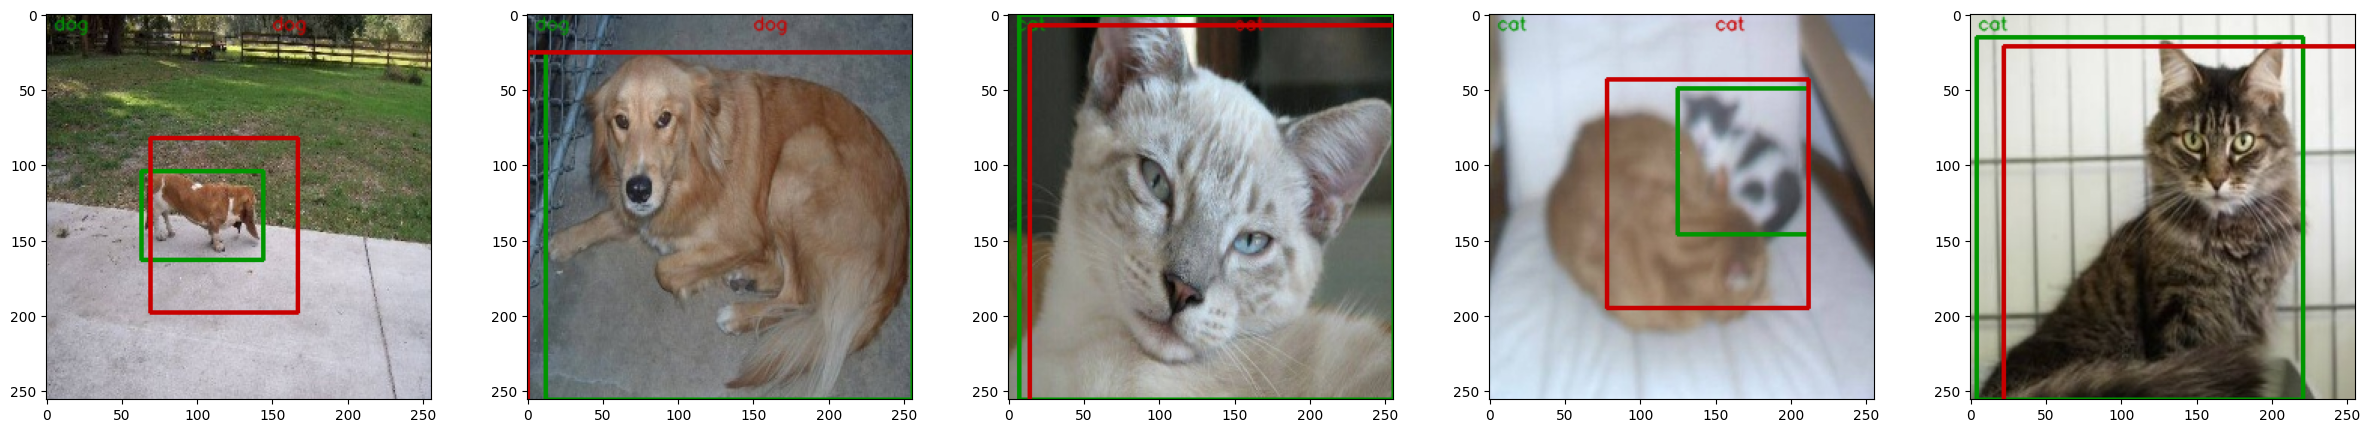

In [51]:
# Green: ground truth
imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (5, 10))
# Red: predicted

pred_classes_=[]
for i in range(0,num_imgs-1):
    temp=np.array([pred_classes[i]])
    pred_classes_.append(temp)
imgs = draw_predictions(imgs, pred_classes_, pred_bboxes, [(200, 0, 0)], (150, 10))

fig = plt.figure(figsize=(30*nrows, num_imgs))
k, j = 1, 1

for img in imgs:
    if j > ncols and k < nrows:
        k += 1
        j = 1
    fig.add_subplot(k, num_imgs, j)
    plt.imshow(img)
    j += 1

plt.show()

In [54]:
torch.save(model, 'pretrained_model_71.pth')

# Submission total

In [55]:
# Perform inference on cpu in order to avoid memory problems
device = 'cuda'
model = model.to(device)

test_root_dir = osp.join(DATA_DIR, "images")
test_df = pd.read_csv(osp.join(DATA_DIR, "test.csv"))

test_ds = PetsDataset(test_df, root_dir=test_root_dir, labeled=False, transform=eval_transforms)
test_data = DataLoader(test_ds, batch_size=1, num_workers=cpu_count(), shuffle=False)

class_preds = []
bbox_preds = []

for batch in test_data:
    batch_preds = model(batch['image'].float().to(device))

    class_pred = batch_preds['class_id'].argmax(-1).detach().cpu().numpy()
    bbox_pred = batch_preds['bbox'].detach().cpu().numpy()

    class_preds.append(class_pred.squeeze())
    bbox_preds.append(bbox_pred.squeeze())

In [56]:
class_preds = np.array(class_preds)
bbox_preds = np.array(bbox_preds)

In [57]:
submission = pd.DataFrame(
    index=test_df.filename,
    data={
        'class': class_preds,
        # Descomentar esta línea cuando generen el archivo de submissions final,
        # para incluir las predicciones de su modelo para regresión
        #'bbox': bbox_preds
    }
)
submission

,class
filename,
image.3401.jpg,1
image.3325.jpg,1
image.3242.jpg,1
image.3218.jpg,1
image.797.jpg,0
...,...
image.839.jpg,0
image.892.jpg,0
image.689.jpg,0


In [58]:
submission['class']=submission['class'].replace(id2obj)

In [59]:
submission.to_csv('submission_35.csv')

In [60]:
submission["x_min"] = bbox_preds[:, 0]*h
submission["y_min"] = bbox_preds[:, 1]*h
submission["x_max"] = bbox_preds[:, 2]*h
submission["y_max"] = bbox_preds[:, 3]*h

In [61]:
submission


,class,x_min,y_min,x_max,y_max
filename,,,,,
image.3401.jpg,dog,22.406111,23.347782,265.172882,257.877777
image.3325.jpg,dog,12.014308,34.459908,280.287140,281.867584
image.3242.jpg,dog,28.189787,10.950758,240.962158,264.547546
image.3218.jpg,dog,23.931131,28.160553,235.917480,256.604492
image.797.jpg,cat,36.058136,15.886509,248.008667,256.887177
...,...,...,...,...,...
image.839.jpg,cat,21.545738,18.551317,266.007996,273.168671
image.892.jpg,cat,47.816658,39.352085,290.836548,289.862762
image.689.jpg,cat,20.109190,17.413309,250.904449,256.788910


In [62]:
submission.to_csv('submission_35_Classify_and_Localization.csv')